# Text Classification of StackOverflow using BiLSTM RNNs with deep self-attention

In [1]:
import sys
import os
from os import pardir, getcwd
from os.path import join, abspath
PARENT_DIRECTORY = abspath(join(getcwd(), pardir))
sys.path.insert(0, PARENT_DIRECTORY)

import warnings
import sklearn.exceptions
import talos as ta
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from definitions import  TALOS_DIR
from app.preprocessing import (load_dataset, load_embeddings,
                               preprocess_data, save_embeddings_matrix)
from app.models import load_bi_lstm_model, find_best_model_over_scan_logs
from app.metrics import *

#Comment out In case of Testing use only a set of the tags as dataset
# tags_categories = ['c', 'python', 'java']
# RUN_STATE = 'testing'

#Comment out In case of Production use all the tags of the dataset
tags_categories = "__all__"
RUN_STATE = 'production'

Using TensorFlow backend.


## Preprocessing for the loaded Dataset
1. Format into *lowercase*
2. Remove some of the *punctuation* characters
3. Remove *Numbers*
4. Remove *stopwords*
5. Remove *links*

In [2]:
data = load_dataset(tags_categories=tags_categories, load_from_pickle=True)
classes_counts =data['tags'].value_counts().where(lambda cls: cls > 0).dropna() 
Classes = list(classes_counts.index)
Nclasses = len(Classes)
print(classes_counts, Classes, Nclasses)

sql              2000
ruby-on-rails    2000
android          2000
angularjs        2000
asp.net          2000
c                2000
c#               2000
c++              2000
css              2000
html             2000
ios              2000
iphone           2000
java             2000
javascript       2000
jquery           2000
mysql            2000
objective-c      2000
php              2000
python           2000
.net             2000
Name: tags, dtype: int64 ['sql', 'ruby-on-rails', 'android', 'angularjs', 'asp.net', 'c', 'c#', 'c++', 'css', 'html', 'ios', 'iphone', 'java', 'javascript', 'jquery', 'mysql', 'objective-c', 'php', 'python', '.net'] 20


 ### Hyper parameter tuning for the  model

In [3]:
# 70% Train & 30% Test
# 70% Train-Dev % 30* Train-Dev 
embeddings_voc, embeddings_vec = load_embeddings(load_from_pickle=True)
model_data = preprocess_data(data, 'tags', 'post', cv_split_dev=0.125)
embeddings_matrix_path = save_embeddings_matrix(embeddings_voc, embeddings_vec, model_data['words_index'])


In [ ]:
model_data['x_train'][4]

### UniStacked RNN with BiLSTM & MLP on top of it

In [4]:
###### Production configuration
rnn_deep_lstm_config = {
    "model_type": ["keras_deep_LSTM_model"],
    "embedding_dim": [embeddings_vec.shape[1]],
    "lstm_size": [200],
    "dense": [300],
    "embeddings_matrix_path": [embeddings_matrix_path],
    "visualize_process": [True],
    "with_early_stoping": [True],
    "multistack_run": [False],
    'early_stopping':[True],
    'early_stopping_config__monitor': ['val_f1'],
    'early_stopping_config__min_delta': [0],
    'early_stopping_config__patience': [5],
    'early_stopping_config__mode': ['max'],
    "embeddings_dropout": [0.2],
    "var_dropout": [0.2, 0.6],
    "mlp_dropout": [0.2],
    "mlp_activation": ["softmax"],
    "rnn_activation": ["relu", "tanh"],
    "optimizer": ["Nadam", "Adam"],
    "batch_size": [32, 64],
    "epochs": [3 if RUN_STATE == 'testing' else 10]
}

In [5]:
TALOS_LSTM_DEEP_LOG_FILENAME = 'talos_lstm_deep_log'
talos_lstm_deep_log_pathname = os.path.join(TALOS_DIR, TALOS_LSTM_DEEP_LOG_FILENAME)

history_model = ta.Scan(model_data['x_train'],
                        model_data['y_train'],
                        x_val=model_data['x_train_dev'],
                        y_val=model_data['y_train_dev'],
                        model=load_bi_lstm_model,
                        params=rnn_deep_lstm_config,
                        grid_downsample=0.1,
                        print_params=True,
                        last_epoch_value=True,
                        seed=(123),
                        dataset_name=talos_lstm_deep_log_pathname
                        )


  0%|          | 0/1 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W0714 19:11:43.917241 140218115942208 deprecation_wrapper.py:119] From /home/giannhs/miniconda3/envs/text_analytics/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 19:11:43.933486 140218115942208 deprecation_wrapper.py:119] From /home/giannhs/miniconda3/envs/text_analytics/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 19:11:43.937669 140218115942208 deprecation_wrapper.py:119] From /home/giannhs/miniconda3/envs/text_analytics/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0714 19:11:43.956440 140218115942208 deprecation_wrapper.py:119] From /home/giannhs/minicon

{'model_type': 'keras_deep_LSTM_model', 'embedding_dim': 300, 'lstm_size': 200, 'dense': 300, 'embeddings_matrix': array([[ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.0363, -0.0601, -0.079 , ...,  0.0515,  0.0123, -0.0028],
       ...,
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.1047,  0.0371, -0.0528, ...,  0.1238,  0.0719, -0.0474],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]]), 'visualize_process': True, 'with_early_stoping': True, 'multistack_run': False, 'early_stopping': True, 'early_stopping_config__monitor': 'val_f1', 'early_stopping_config__min_delta': 0, 'early_stopping_config__patience': 5, 'early_stopping_config__mode': 'max', 'embeddings_dropout': 0.2, 'var_dropout': 0.6, 'mlp_dropout': 0.2, 'mlp_activation': 'softmax', 'rnn_activation': 'tanh', 'optimizer': 'Adam', 'batch_size': 64, 'epochs': 3}


W0714 19:11:44.188656 140218115942208 deprecation.py:506] From /home/giannhs/miniconda3/envs/text_analytics/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0714 19:11:44.416015 140218115942208 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0714 19:11:44.436372 140218115942208 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0714 19:11:44.459633 140218115942208 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0714 19:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 600, 300)          6000600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 600, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600, 400)          801600    
_________________________________________________________________
deep_attention_1 (DeepAttent [(None, 400), (None, 600) 160801    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               120300    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 903       
Total para


Epoch 00001: val_accuracy improved from -inf to 0.92190, saving model to keras_deep_LSTM_model

Epoch 00001: val_f1 improved from -inf to 0.87865, saving model to keras_deep_LSTM_model



Epoch 00002: val_accuracy improved from 0.92190 to 0.95937, saving model to keras_deep_LSTM_model

Epoch 00002: val_f1 improved from 0.87865 to 0.93806, saving model to keras_deep_LSTM_model



Epoch 00003: val_accuracy improved from 0.95937 to 0.97397, saving model to keras_deep_LSTM_model

Epoch 00003: val_f1 improved from 0.93806 to 0.96060, saving model to keras_deep_LSTM_model


100%|██████████| 1/1 [11:46<00:00, 706.92s/it]


    Finds the best model configuration set for the LSTM with deep self-attention, after the Talos Scanning.

In [6]:
report_talos = ta.Reporting(history_model)
best_model_idx = report_talos.data['val_f1'].idxmax()
best_model_params = report_talos.data.loc[best_model_idx].to_dict()
best_model_params

{'round_epochs': 3,
 'val_loss': 0.14250475163970674,
 'val_precision': 0.9670416695731027,
 'val_recall': 0.9542857142857143,
 'val_f1': 0.9605989728655134,
 'val_accuracy': 0.9739682515462239,
 'val_categorical_accuracy': 0.96,
 'loss': 0.17908514921002242,
 'precision': 0.9499369137303358,
 'recall': 0.9303401360544218,
 'f1': 0.9399723597935268,
 'accuracy': 0.9604535161232461,
 'categorical_accuracy': 0.9395918367346939,
 'model_type': 'keras_deep_LSTM_model',
 'embedding_dim': 300,
 'lstm_size': 200,
 'dense': 300,
 'embeddings_matrix': '[[ 0.      0.      0.     ...  0.      0.      0.    ]\n [ 0.      0.      0.     ...  0.      0.      0.    ]\n [ 0.0363 -0.0601 -0.079  ...  0.0515  0.0123 -0.0028]\n ...\n [ 0.      0.      0.     ...  0.      0.      0.    ]\n [ 0.1047  0.0371 -0.0528 ...  0.1238  0.0719 -0.0474]\n [ 0.      0.      0.     ...  0.      0.      0.    ]]',
 'visualize_process': 'True',
 'with_early_stoping': 'True',
 'multistack_run': 'False',
 'early_stopping'

    Train return am RNN LSTM model with the the best configuration set.

In [5]:
if RUN_STATE == 'testing':
    # Train and Load the best model of given the tuned featured model
    best_model_params['early_stopping'] = True
    best_model_params['with_early_stopping'] = True
    best_model_params['visualize_process'] = True
    model_history, model = load_bi_lstm_model(model_data['x_train'],
                                              model_data['y_train'],
                                              model_data['x_train_dev'],
                                              model_data['y_train_dev'],
                                              best_model_params)

NameError: name 'best_model_params' is not defined

### Visualize Model History Scores

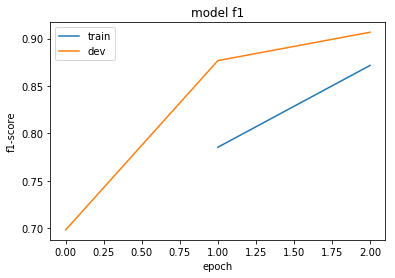

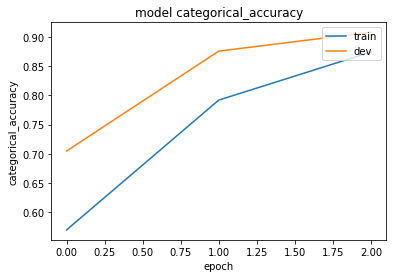

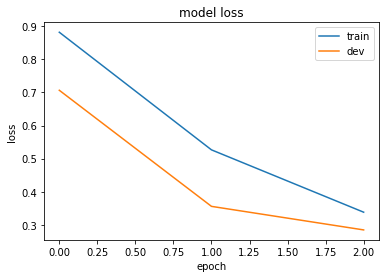

In [10]:
if RUN_STATE == 'testing':
    from app.visualization import plot_history_metrics
    import matplotlib.pylab as plt

    %matplotlib inline
    plot_history_metrics(history_obj=model_history)

### Evaluate performance model

Evaluates the performance of the best trained model in the **test** dataset. 

In [12]:
if RUN_STATE == 'testing':
    score = model.evaluate(model_data['x_test'],
                           model_data['y_test'],
                           batch_size=best_model_params['batch_size'],
                           verbose=1)

    print('\nTest f1: %.4f' % (score[1]))
    print('\nTest categorical accuracy: %.4f'% (score[2]))

1800/1800 [==============================] - 41s 23ms/step

Test f1: 0.8974

Test categorical accuracy: 0.8789


### Visualize Prediction Perfomance  model

[[0 1 0]
 [0 0 1]
 [1 0 0]
 ...
 [0 1 0]
 [1 0 0]
 [1 0 0]]
--------------------------------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0      0.906     0.920     0.913       600
           1      0.964     0.797     0.872       600
           2      0.839     0.920     0.878       600

   micro avg      0.897     0.879     0.888      1800
   macro avg      0.903     0.879     0.888      1800
weighted avg      0.903     0.879     0.888      1800
 samples avg      0.879     0.879     0.879      1800

--------------------------------------------------------------------------------
Accuracy Score: 88.78%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0      0.894     0.927     0.910       600
 

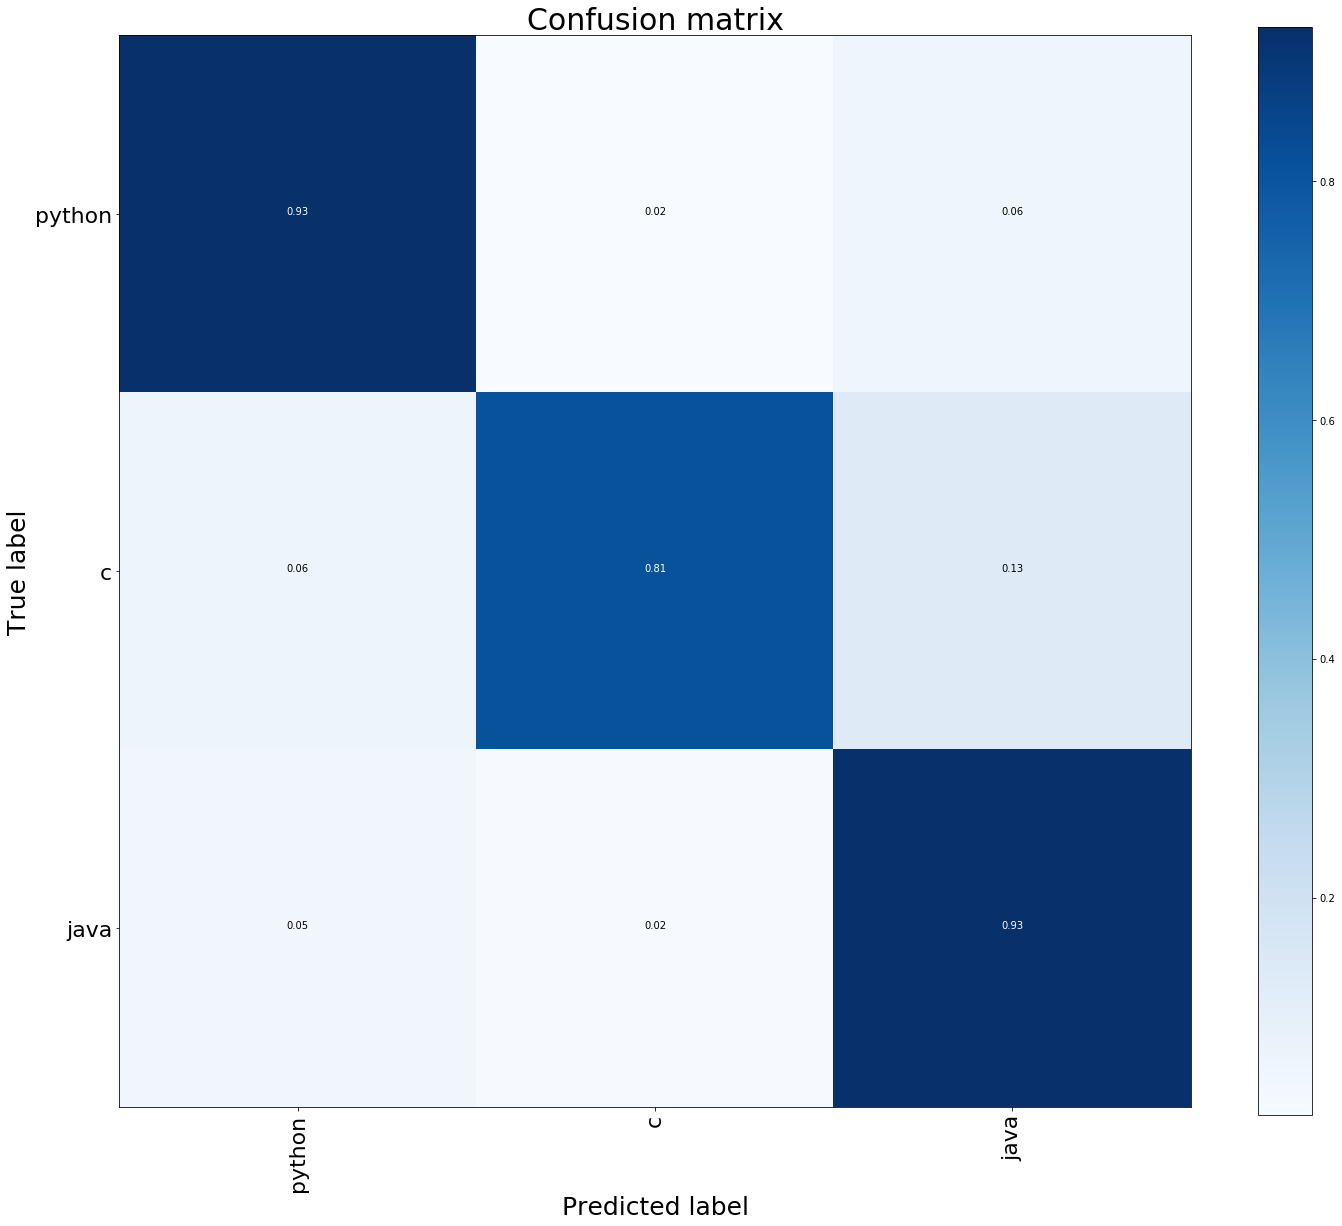

In [21]:
if RUN_STATE == 'testing':
    import numpy as np
    from app.visualization import (plot_prediction_metrics,
                                   create_clf_report,
                                   plot_roc_curve,
                                   plot_precision_recall_curve,
                                   plot_confusion_matrix)
    import matplotlib.pylab as plt

    prediction_val = model.predict(model_data['x_test'], batch_size=best_model_params['batch_size'])

    # returns each entry result to the classification with the relevant probabilities
    y_pred_processed = np.array([np.argmax(val) for val in prediction_val])
    y_true_processed = np.array([np.argmax(val) for val in model_data['y_test']])

    # If you want to see the OneVSAll ROC Curves of each class uncomment the below line
    # plot_roc_curve(model_data['y_test'], prediction_val, Classes, 1)

    # If you want to see the OneVSAll Precission Recall Curves of each class, comment out the below line
    # plot_precision_recall_curve(model_data['y_test'], prediction_val, Classes , 1)

    # If you want to get the Classification Report, comment out the below line
    create_clf_report(model_data['y_test'], (prediction_val > 0.5).astype('int32'),
                      y_true_processed, y_pred_processed)

    # If you want to get the confusion matrix,comment out the below line
    plot_confusion_matrix(y_true_processed, y_pred_processed, Classes)

### Multistack RNN with BiLSTM & MLP on top of it

In [5]:
TALOS_LSTM_DEEP_MULTI_LOG_FILENAME = 'talos_lstm_deep_multi_log'
talos_lstm_deep_multi_log_pathname = os.path.join(TALOS_DIR, TALOS_LSTM_DEEP_MULTI_LOG_FILENAME)


###### Production configuration
rnn_deep_lstm_multi_config = rnn_deep_lstm_config.copy()
rnn_deep_lstm_multi_config.update({
    "model_type": ["keras_deep_LSTM_multi_model"],
    "multistack_run": [True],
})

history_model_multi = ta.Scan(model_data['x_train'],
                        model_data['y_train'],
                        x_val=model_data['x_train_dev'],
                        y_val=model_data['y_train_dev'],
                        model=load_bi_lstm_model,
                        params=rnn_deep_lstm_multi_config,
                        grid_downsample=0.1,
                        print_params=True,
                        last_epoch_value=True,
                        seed=(123),
                        dataset_name=talos_lstm_deep_multi_log_pathname
                        )


  0%|          | 0/1 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W0714 20:40:17.210367 139887382910784 deprecation_wrapper.py:119] From /home/giannhs/miniconda3/envs/text_analytics/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 20:40:17.226355 139887382910784 deprecation_wrapper.py:119] From /home/giannhs/miniconda3/envs/text_analytics/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 20:40:17.282724 139887382910784 deprecation_wrapper.py:119] From /home/giannhs/miniconda3/envs/text_analytics/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0714 20:40:17.294373 139887382910784 deprecation_wrapper.py:119] From /home/giannhs/minicon

{'model_type': 'keras_deep_LSTM_multi_model', 'embedding_dim': 300, 'lstm_size': 200, 'dense': 300, 'embeddings_matrix_path': 'embeddings-matrix-pickle', 'visualize_process': True, 'with_early_stoping': True, 'multistack_run': True, 'early_stopping': True, 'early_stopping_config__monitor': 'val_f1', 'early_stopping_config__min_delta': 0, 'early_stopping_config__patience': 5, 'early_stopping_config__mode': 'max', 'embeddings_dropout': 0.2, 'var_dropout': 0.6, 'mlp_dropout': 0.2, 'mlp_activation': 'softmax', 'rnn_activation': 'relu', 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 3}


W0714 20:40:17.413277 139887382910784 deprecation.py:506] From /home/giannhs/miniconda3/envs/text_analytics/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0714 20:40:17.591058 139887382910784 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0714 20:40:17.613814 139887382910784 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0714 20:40:17.641900 139887382910784 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0714 20:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 600, 300)          6000600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 600, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600, 400)          801600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 600, 200)          480800    
_________________________________________________________________
deep_attention_1 (DeepAttent [(None, 200), (None, 600) 40401     
_________________________________________________________________
dense_1 (Dense)              (None, 300)               60300     
__________


Epoch 00001: val_accuracy improved from -inf to 0.91873, saving model to keras_deep_LSTM_multi_model

Epoch 00001: val_f1 improved from -inf to 0.87368, saving model to keras_deep_LSTM_multi_model



Epoch 00002: val_accuracy improved from 0.91873 to 0.95238, saving model to keras_deep_LSTM_multi_model

Epoch 00002: val_f1 improved from 0.87368 to 0.92648, saving model to keras_deep_LSTM_multi_model



Epoch 00003: val_accuracy improved from 0.95238 to 0.96127, saving model to keras_deep_LSTM_multi_model

Epoch 00003: val_f1 improved from 0.92648 to 0.94132, saving model to keras_deep_LSTM_multi_model


100%|██████████| 1/1 [21:51<00:00, 1311.01s/it]


    Finds the best model configuration set for the Multi LSTM with deep self-attention, after the Talos Scanning.

In [ ]:
report_talos_multi = ta.Reporting(history_model_multi)
best_model_idx = report_talos_multi.data['val_f1'].idxmax()
best_model_params_multi = report_talos_multi.data.loc[best_model_idx].to_dict()
best_model_params_multi

    Train return a Multistack RNN LSTM model with the the best configuration set.

In [ ]:
if RUN_STATE == 'testing':
    # Train and Load the best model of given the tuned featured model
    model_history_multi, model_multi = load_bi_lstm_model(model_data['x_train'],
                                                          model_data['y_train'],
                                                          model_data['x_train_dev'],
                                                          model_data['y_train_dev'],
                                                          best_model_params)

In [ ]:
### Visualize Model History Scores

In [ ]:
if RUN_STATE == 'testing':
    from app.visualization import plot_history_metrics
    import matplotlib.pylab as plt

    %matplotlib inline
    plot_history_metrics(history_obj=model_history_multi)

### Evaluate performance model

Evaluates the performance of the best trained model in the **test** dataset. 

In [12]:
if RUN_STATE == 'testing':
    score_multi = model_multi.evaluate(model_data['x_test'],
                                       model_data['y_test'],
                                       batch_size=best_model_params_multi['batch_size'],
                                       verbose=1)

    print('\nTest f1: %.4f' % (score_multi[1]))
    print('\nTest categorical accuracy: %.4f'% (score_multi[2]))

1800/1800 [==============================] - 41s 23ms/step

Test f1: 0.8974

Test categorical accuracy: 0.8789


In [ ]:
### Visualize Prediction Perfomance  model

In [ ]:
if RUN_STATE == 'testing':
    import numpy as np
    from app.visualization import (plot_prediction_metrics,
                                   create_clf_report,
                                   plot_roc_curve,
                                   plot_precision_recall_curve,
                                   plot_confusion_matrix)
    import matplotlib.pylab as plt

    prediction_val_multi = model.predict(model_data['x_test'], batch_size=best_model_params['batch_size'])

    # returns each entry result to the classification with the relevant probabilities
    y_pred_processed_multi = np.array([np.argmax(val) for val in prediction_val_multi])
    y_true_processed_multi = np.array([np.argmax(val) for val in model_data['y_test']])

    # If you want to see the OneVSAll ROC Curves of each class uncomment the below line
    # plot_roc_curve(model_data['y_test'], prediction_val, Classes, 1)

    # If you want to see the OneVSAll Precission Recall Curves of each class, comment out the below line
    # plot_precision_recall_curve(model_data['y_test'], prediction_val, Classes , 1)

    # If you want to get the Classification Report, comment out the below line
    create_clf_report(model_data['y_test'], (prediction_val_multi > 0.5).astype('int32'),
                      y_true_processed_multi, y_pred_processed_multi)

    # If you want to get the confusion matrix,comment out the below line
    plot_confusion_matrix(y_true_processed_multi, y_pred_processed_multi, Classes)